## Формулировка задачи
Представим, что вы - разработчик в отделе машинного обучения и перед вами поставлена задача разработать модуль автоматического обнаружения русскоязычных текстов. На вход подаётся большой набор документов, среди которых нужно обнаружить тексты, содержащие значительные фрагменты на русском языке.

## Решение

In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
import time
from tqdm import tqdm
import unicodedata

Для начала посмотрим на данные, приведенные в качестве примеров, чтобы понять, с чем имеем дело. Отфильтруем тексты, в которых содержится хотя бы одна буква русского алфавита (что является необходимым условием для русскоязычности текста, транслит не рассматриваем)

In [2]:
data_dir = 'data'
filenames = sorted(os.listdir(data_dir))

In [3]:
russian_contents = []
token_counts = []
pattern = re.compile(r'[а-яА-Я]+')

In [4]:
for filename in filenames:
    with open(os.path.join(data_dir, filename)) as f:
        content = f.read()
        token_counts.append(len(content.split()))
        if pattern.search(content):
            russian_contents.append(content)

print(f'Буквы русского алфавита содержат {len(russian_contents)} из {len(filenames)} текстов в папке',
      f'({round(len(russian_contents) / len(filenames) * 100, 2)}%)')

Буквы русского алфавита содержат 386 из 2654 текстов в папке (14.54%)


Посмотрим на распределение количества токенов в текстах.

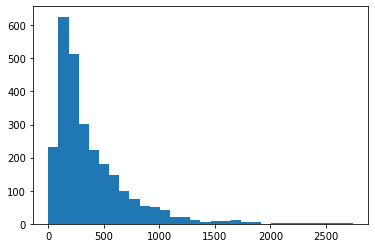

In [5]:
plt.hist(token_counts, bins=30);

In [6]:
np.mean(token_counts)

381.24642049736246

In [7]:
# for content in russian_contents:
#     print(content)
#     print('\n\n---------------------------------------------------------------\n\n')

Беглый просмотр отфильтрованных текстов показывает, что все они являются текстами, написанными преимущественно на одном языке. Большинство из них - на русском языке, однако встречаются и тексты на украинском или белорусском языках, а также один текст на языке с преимущественно латинскими буквами в алфавите.

In [8]:
len(russian_contents) / len(filenames)

0.14544084400904295

# Сравнение методов определения языка текста

Большая часть методов взята отсюда: https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language.

Для оценки качества будем использовать:
1. Датасет WiLI (https://arxiv.org/abs/1801.07779), состоящий из фрагментов статей Википедии на разных языках (относительно длинные тексты)
2. Датасет twituser (https://www.aclweb.org/anthology/W14-1303/), состоящий из твитов (короткие тексты)

### обрабатываем датасет WiLI

In [9]:
! wget https://zenodo.org/record/841984/files/wili-2018.zip -P ./datasets
! unzip datasets/wili-2018.zip -d datasets/wili-2018
! wget https://people.eng.unimelb.edu.au/tbaldwin/data/lasm2014-twituser-v1.tgz -P ./datasets
! tar --extract --file datasets/lasm2014-twituser-v1.tgz -C datasets

--2020-07-19 19:10:54--  https://zenodo.org/record/841984/files/wili-2018.zip
Распознаётся zenodo.org (zenodo.org)… 188.184.117.155
Подключение к zenodo.org (zenodo.org)|188.184.117.155|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 62403646 (60M) [application/octet-stream]
Сохранение в: «./datasets/wili-2018.zip»

wili-2018.zip       100%[===================>]  59,51M  1,13MB/s    за 61s     

2020-07-19 19:11:56 (998 KB/s) - «./datasets/wili-2018.zip» сохранён [62403646/62403646]

Archive:  datasets/wili-2018.zip
  inflating: datasets/wili-2018/x_train.txt  
  inflating: datasets/wili-2018/y_train.txt  
  inflating: datasets/wili-2018/x_test.txt  
  inflating: datasets/wili-2018/y_test.txt  
  inflating: datasets/wili-2018/labels.csv  
  inflating: datasets/wili-2018/README.txt  
  inflating: datasets/wili-2018/urls.txt  
--2020-07-19 19:11:57--  https://people.eng.unimelb.edu.au/tbaldwin/data/lasm2014-twituser-v1.tgz
Распознаётся people.eng.uni

In [10]:
texts = dict()
labels = dict()
binary_labels = dict()

In [11]:
wili_token_counts = []

with open('datasets/wili-2018/x_test.txt') as f:
    wili_texts = []
    for line in f:
        text = line.rstrip()
        wili_token_counts.append(len(text.split()))
        wili_texts.append(text)

with open('datasets/wili-2018/y_test.txt') as f:
    wili_labels = [line.rstrip() for line in f]



In [12]:
# ошибочно русский текст, исправляем метку
ind = 12492
print(wili_labels[ind], wili_texts[ind])
wili_labels[ind] = 'eng'

rus Townes, H. T. (1969): Genera of Ichneumonidae, Part 3 (Lycorininae, Banchinae, Scolobatinae =Ctenopelmatinae), Porizontinae =Campopleginae). — Memoirs of the American Entomological Institute 13: 1-307.


Среднее число токенов в WiLI 54.6116085106383


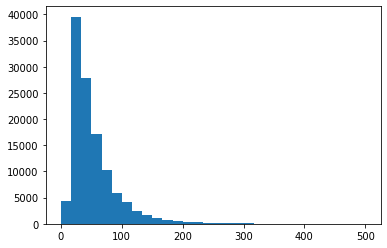

In [13]:
plt.hist(wili_token_counts, bins=30, range=(0, 500))
print('Среднее число токенов в WiLI', np.mean(wili_token_counts))

In [14]:
examples = dict()
examples['wili'] = wili_texts[55171]
print(examples['wili'])

Труд М. В. Ломоносова «Явление Венеры на Солнце, наблюдённое в Санктпетербургской Императорской Академии Наук Майя 26 дня 1761 года» (Санкт-Петербург: Типография Академии наук, 1761) был напечатан на русском и немецком языках (нем. Erscheinung der Venus vor der Sonne beobachtet bei der Kaiserlichen Akademie der Wissenschaften: Aus dem Russischen übersetzt. St. Petersbourg, 1761) и, следовательно, были известны в Западной Европе, поскольку публикации Академии рассылались в её крупнейшие научные центры, однако открытие атмосферы на Венере приписывалось И. И. Шрётеру и Ф. В. Гершелю. Председатель Американского химического общества профессор Колумбийского университета А. Смит в 1912 году писал: «Открытие, сделанное при этом Ломоносовым о наличии атмосферы на этой планете, обычно приписывают Шретеру и Гершелю», Любопытно, что сам М. В. Ломоносов этому открытию не придавал большого значения, во всяком случае, оно даже не упомянуто в составленном им списке работ, которые он относил к наиболее

В датасете WiLI содержится много фрагментов текста, извлеченных из списка литературы. Такие фрагменты имеют метку, совпадающую с языком статьи, хотя название книги и имена автора могут быть на другом языке. Чтобы не использовать такие примеры при оценке качества идентификации русского языка, уберем их из датасета. Для фильтрации используется регулярное выражение, распознающее конструкции вида "с. 237-239", а также символы "//". Было проверено, что почти все тексты, содержащие такие конструкции, являются фрагментом списка литературы.

In [15]:
def check_literature(text):
    # грубая проверка, является ли текст фрагментом списка литературы
    if '//' in text:
        return True
    if re.search(r' [сС]\.[ ]?\d+-?\d+', text):
        return True
    return False

In [16]:
texts['wili'] = []
labels['wili'] = []

for i in range(len(wili_texts)):
    if not check_literature(wili_texts[i]):
        texts['wili'].append(wili_texts[i])
        labels['wili'].append(wili_labels[i])

In [17]:
binary_labels['wili'] = [int(label == 'rus') for label in labels['wili']]

### обрабатываем датасет twituser

In [18]:
import json 
with open('datasets/twituser-v1/twituser') as f:
    twitter_data = [json.loads(line) for line in f.readlines()]

In [19]:
twitter_df = pd.DataFrame(twitter_data)
twitter_df['label'] = (twitter_df['lang'] == 'ru').astype(int)

texts['twit'] = list(twitter_df['text'])
labels['twit'] = list(twitter_df['lang'])
binary_labels['twit'] = list(twitter_df['label'])

In [20]:
# for i, label in enumerate(binary_labels['twit']):
#     if label == 1:
#         print(i)
#         print(texts['twit'][i])
#         print('\n-----------------------\n')

In [21]:
examples['twit'] = texts['twit'][1611]
print(examples['twit'])

@YashaMyaus no. he's 36. it's too much *тренируюсь на иностранном


Среднее число токенов в twituser 10.967132176611653


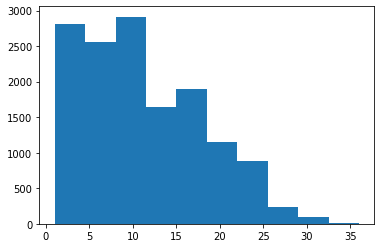

In [22]:
twit_token_counts = [len(text.split()) for text in texts['twit']]
plt.hist(twit_token_counts)
print('Среднее число токенов в twituser', np.mean(twit_token_counts))

### служебные функции

In [23]:
predictions = defaultdict(lambda: defaultdict(list))
binary_predictions = defaultdict(lambda: defaultdict(list))
results = []
data_names = ['wili', 'twit']

In [24]:
def estimate_quality(method_name, data_name):
    # оценка качества модели
    y_true = binary_labels[data_name]
    y_pred = binary_predictions[method_name][data_name]
    precision = round(100 * precision_score(y_true, y_pred), 2)
    recall = round(100 * recall_score(y_true, y_pred), 2)
    f1 = round(100 * f1_score(y_true, y_pred), 2)
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

    print('Contingency table:')
    print(pd.crosstab(pd.Series(y_true), pd.Series(y_pred), rownames=['Actual'], colnames=['Predicted'],margins=True))
    return precision, recall, f1
    
def sample_errors(method_name, data_name, n=5, output_dir='errors'):
    # запись в файл n случайных ошибок определения языка для двух типов ошибки - FP и FN
    y_true = binary_labels[data_name]
    y_pred = binary_predictions[method_name][data_name]
    
    error_indices = {
        'False Positive': [],
        'False Negative': [],
    }

    for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
        if yt == 1 and yp == 0:
            error_indices['False Negative'].append(i)
        elif yt == 0 and yp == 1:
            error_indices['False Positive'].append(i)
    
    
    if not os.path.isdir(output_dir):    
        os.mkdir(output_dir)
    output_file = os.path.join(output_dir, f'{method_name}_{data_name}_errors.txt')
    with open(output_file, 'w') as f:
        for error_type, indices in error_indices.items():
            f.write(f'{error_type} samples:\n\n')
            if len(indices) > n:
                indices = np.random.choice(indices, n, replace=False)

            for i in indices:
                f.write(f'Index: {i}\n')
                f.write(f'Text:\n{texts[data_name][i]}\n')
                f.write(f'Actual language: {labels[data_name][i]}\n')
                f.write(f'Predicted language: {predictions[method_name][data_name][i]}\n')
                f.write('-----------------\n')
            f.write('\n\n\n')


def run_experiments(method_name, detector_func):
    # проверка функции определения языка
    result_info = {
        'method_name': method_name,
    }


    for data_name in data_names:
        predictions[method_name][data_name] = []
        binary_predictions[method_name][data_name] = []

        start_time = time.time()
        for text in tqdm(texts[data_name]):
            prediction, binary_prediction = detector_func(text)
            predictions[method_name][data_name].append(prediction)
            binary_predictions[method_name][data_name].append(binary_prediction)
        exec_time = time.time() - start_time

        print(f'{data_name} quality:')

        prec, rec, f1 = estimate_quality(method_name, data_name)
        result_info[f'{data_name}_precision'] = prec
        result_info[f'{data_name}_recall'] = rec
        result_info[f'{data_name}_f1'] = f1
        result_info[f'{data_name}_time'] = round(exec_time, 2)

    return result_info


## Оценка качества

Далее оценим качество нескольких методов идентификации текста. Будем также измерять время работы методов.

## Regex baseline

In [25]:
method_name = 'regex'

def regex_detector_func(text):
    search_result = pattern.search(text)
    prediction = 'ru' if search_result else 'unknown'
    binary_prediction = 1 if search_result else 0
    return prediction, binary_prediction

result_info = run_experiments(method_name, regex_detector_func)
    
results.append(result_info)


100%|██████████| 117072/117072 [00:00<00:00, 142661.15it/s]


wili quality:


100%|██████████| 14178/14178 [00:00<00:00, 498468.91it/s]

Precision: 2.96
Recall: 100.0
F1: 5.75
Contingency table:
Predicted       0      1     All
Actual                          
0          100997  15599  116596
1               0    476     476
All        100997  16075  117072
twit quality:
Precision: 55.18
Recall: 99.79
F1: 71.06
Contingency table:
Predicted      0    1    All
Actual                      
0          13298  394  13692
1              1  485    486
All        13299  879  14178


## CLD2

In [26]:
import pycld2 as cld2

method_name = 'cld2'
for data_name in data_names:
    print(f'{data_name} example predictions:')
    _, _, languages, vectors = cld2.detect(examples[data_name], returnVectors=True)
    print(languages)
    print(vectors)
    print()


wili example predictions:
(('RUSSIAN', 'ru', 87, 536.0), ('GERMAN', 'de', 9, 965.0), ('Unknown', 'un', 0, 0.0))
((0, 412, 'RUSSIAN', 'ru'), (412, 151, 'GERMAN', 'de'), (563, 61, 'Unknown', 'un'), (624, 1163, 'RUSSIAN', 'ru'))

twit example predictions:
(('RUSSIAN', 'ru', 58, 710.0), ('ENGLISH', 'en', 39, 899.0), ('Unknown', 'un', 0, 0.0))
((0, 88, 'Unknown', 'un'),)



In [27]:

def cld2_detector_func(text):
    for best_effort in [False, True]:
        try:
            _, _, languages = cld2.detect(text, bestEffort=best_effort)
        except cld2.error:
            text = ''.join([l for l in text if unicodedata.category(l)[0] not in ('S', 'M', 'C')])
            _, _, languages = cld2.detect(text, bestEffort=best_effort)

        top_lang = sorted(languages, key=lambda l: l[2], reverse=True)[0][1]
        if top_lang == 'un' and not best_effort:
            continue # try with best effort
        prediction = top_lang
        binary_prediction = int(top_lang == 'ru')
        break 
    return prediction, binary_prediction

result_info = run_experiments(method_name, cld2_detector_func)
    
results.append(result_info)


100%|██████████| 117072/117072 [00:04<00:00, 24330.21it/s]


wili quality:


 55%|█████▍    | 7783/14178 [00:00<00:00, 77825.06it/s]

Precision: 26.04
Recall: 97.48
F1: 41.1
Contingency table:
Predicted       0     1     All
Actual                         
0          115278  1318  116596
1              12   464     476
All        115290  1782  117072


100%|██████████| 14178/14178 [00:00<00:00, 76849.81it/s]


twit quality:
Precision: 99.07
Recall: 87.45
F1: 92.9
Contingency table:
Predicted      0    1    All
Actual                      
0          13688    4  13692
1             61  425    486
All        13749  429  14178


In [28]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

Значительную часть False Positive срабатываний алгоритм дает на языках малых народов РФ в датасете WiLI. False Negative срабатывания на WiLI в основном происходят, когда алгоритм не справляется с определением языка и выдает unknown. Кроме того, как видно из примеров, часть ошибок присутствует и в разметке датасетов.

## Span-based CLD2

In [29]:
method_name = 'cld2_span'

def cld2_span_detector_func(text):
    absolute_threshold = 150
    relative_threshold = 0.4
    try:
        _, _, languages, vectors = cld2.detect(text, bestEffort=False, returnVectors=True)
    except cld2.error:
        text = ''.join([l for l in text if unicodedata.category(l)[0] not in ('S', 'M', 'C')])
        _, _, languages, vectors = cld2.detect(text, bestEffort=False, returnVectors=True)

    is_russian = False

    byte_count = len(text.encode())
    for vector in vectors:
        if vector[3] == 'ru':
            if vector[1] > absolute_threshold or vector[1] / byte_count > relative_threshold:
                is_russian = True
        
    prediction = sorted(languages, key=lambda l: l[2], reverse=True)[0][1]
    binary_prediction = int(is_russian)
    return prediction, binary_prediction

result_info = run_experiments(method_name, cld2_span_detector_func)
    
results.append(result_info)



100%|██████████| 117072/117072 [00:04<00:00, 25549.25it/s]


wili quality:


 64%|██████▍   | 9085/14178 [00:00<00:00, 90846.40it/s]

Precision: 59.36
Recall: 89.92
F1: 71.51
Contingency table:
Predicted       0    1     All
Actual                        
0          116303  293  116596
1              48  428     476
All        116351  721  117072


100%|██████████| 14178/14178 [00:00<00:00, 89853.63it/s]


twit quality:
Precision: 99.7
Recall: 68.11
F1: 80.93
Contingency table:
Predicted      0    1    All
Actual                      
0          13691    1  13692
1            155  331    486
All        13846  332  14178


In [30]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

## langdetect

In [31]:
import langdetect
langdetect.DetectorFactory.seed = 0

In [32]:
method_name = 'langdetect'
for data_name in data_names:
    print(f'{data_name} example predictions:')
    language = langdetect.detect(examples[data_name])
    print(language)
    print()


wili example predictions:
ru

twit example predictions:
ru



In [33]:
def langdetect_detector_func(text):
    try:
        prediction = langdetect.detect(text)
    except langdetect.lang_detect_exception.LangDetectException:
        prediction = 'unknown'
    binary_prediction = int(prediction == 'ru')
    return prediction, binary_prediction

result_info = run_experiments(method_name, langdetect_detector_func)
    
results.append(result_info)


100%|██████████| 117072/117072 [14:40<00:00, 133.03it/s]


wili quality:


  0%|          | 24/14178 [00:00<00:59, 237.31it/s]

Precision: 4.37
Recall: 99.79
F1: 8.37
Contingency table:
Predicted       0      1     All
Actual                          
0          106195  10401  116596
1               1    475     476
All        106196  10876  117072


100%|██████████| 14178/14178 [01:17<00:00, 181.84it/s]

twit quality:
Precision: 95.26
Recall: 86.83
F1: 90.85
Contingency table:
Predicted      0    1    All
Actual                      
0          13671   21  13692
1             64  422    486
All        13735  443  14178


In [34]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

В списке поддерживаемых языков библиотеки langdetect не содержится даже белорусского и казахского, поэтому получается много ложноположительных срабатываний. Тем не менее, полнота получается хорошей.

## guess_language

In [35]:
from guess_language import guess_language
method_name = 'guess_language'
for data_name in data_names:
    print(f'{data_name} example predictions:')
    language = guess_language(examples[data_name])
    print(language)
    print()


wili example predictions:
ru

twit example predictions:
ru



In [36]:
def guess_language_detector_func(text):
    prediction = guess_language(text)
    binary_prediction = int(prediction == 'ru')
    return prediction, binary_prediction

result_info = run_experiments(method_name, guess_language_detector_func)
    
results.append(result_info)

100%|██████████| 117072/117072 [01:59<00:00, 976.33it/s] 


wili quality:


  2%|▏         | 316/14178 [00:00<00:04, 3157.27it/s]

Precision: 18.93
Recall: 89.92
F1: 31.28
Contingency table:
Predicted       0     1     All
Actual                         
0          114763  1833  116596
1              48   428     476
All        114811  2261  117072


100%|██████████| 14178/14178 [00:04<00:00, 3278.10it/s]


twit quality:
Precision: 90.66
Recall: 61.93
F1: 73.59
Contingency table:
Predicted      0    1    All
Actual                      
0          13661   31  13692
1            185  301    486
All        13846  332  14178


In [37]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

## langid

In [38]:
import langid
method_name = 'langid'
for data_name in data_names:
    print(f'{data_name} example predictions:')
    language = langid.classify(examples[data_name])
    print(language)
    print()

wili example predictions:
('ru', -16214.29053735733)

twit example predictions:
('ru', -545.5707614421844)



In [39]:
def langid_detector_func(text):
    prediction = langid.classify(text)[0]
    binary_prediction = int(prediction == 'ru')
    return prediction, binary_prediction

result_info = run_experiments(method_name, langid_detector_func)
    
results.append(result_info)

100%|██████████| 117072/117072 [02:46<00:00, 701.69it/s]


wili quality:


  1%|          | 118/14178 [00:00<00:11, 1175.97it/s]

Precision: 6.96
Recall: 100.0
F1: 13.01
Contingency table:
Predicted       0     1     All
Actual                         
0          110232  6364  116596
1               0   476     476
All        110232  6840  117072


100%|██████████| 14178/14178 [00:13<00:00, 1056.46it/s]


twit quality:
Precision: 95.29
Recall: 87.45
F1: 91.2
Contingency table:
Predicted      0    1    All
Actual                      
0          13671   21  13692
1             61  425    486
All        13732  446  14178


In [40]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

## fasttext large

In [41]:
models_dir = 'models'
if not os.path.isdir(models_dir):
    os.mkdir(models_dir)

In [42]:
! wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P $models_dir
! wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz -P $models_dir

--2020-07-19 19:33:23--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Распознаётся dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)… 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Подключение к dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 131266198 (125M) [application/octet-stream]
Сохранение в: «models/lid.176.bin»

lid.176.bin         100%[===================>] 125,18M  3,81MB/s    за 33s     

2020-07-19 19:33:57 (3,75 MB/s) - «models/lid.176.bin» сохранён [131266198/131266198]

--2020-07-19 19:33:57--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Распознаётся dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)… 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Подключение к dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 938013 (916K) [binary/oct

In [43]:
import fasttext
method_name = 'fasttext_large'
model = fasttext.load_model(os.path.join(models_dir, 'lid.176.bin'))

for data_name in data_names:
    print(f'{data_name} example predictions:')
    language = model.predict(examples[data_name])
    print(language)
    print()

wili example predictions:
(('__label__ru',), array([0.99247408]))

twit example predictions:
(('__label__en',), array([0.62909627]))



In [44]:
def fasttext_large_detector_func(text):
    max_len = 0
    russian_lines_threshold = 1
    russian_lines_count = 0
    for line in text.split('\n'):
        if len(line) > 0:
            labels, probs = model.predict(line)
            line_prediction = labels[0]
            if len(line) > max_len:
                prediction = line_prediction
            if line_prediction == '__label__ru':
                russian_lines_count += 1
    binary_prediction = int(russian_lines_count >= russian_lines_threshold)
    return prediction, binary_prediction

result_info = run_experiments(method_name, fasttext_large_detector_func)
    
results.append(result_info)

100%|██████████| 117072/117072 [00:09<00:00, 11833.62it/s]


wili quality:


 29%|██▉       | 4109/14178 [00:00<00:00, 41086.51it/s]

Precision: 15.46
Recall: 100.0
F1: 26.78
Contingency table:
Predicted       0     1     All
Actual                         
0          113993  2603  116596
1               0   476     476
All        113993  3079  117072


100%|██████████| 14178/14178 [00:00<00:00, 39235.36it/s]


twit quality:
Precision: 92.51
Recall: 94.03
F1: 93.27
Contingency table:
Predicted      0    1    All
Actual                      
0          13655   37  13692
1             29  457    486
All        13684  494  14178


In [45]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

## fasttext small

In [46]:
import fasttext
method_name = 'fasttext_small'
model = fasttext.load_model(os.path.join(models_dir, 'lid.176.ftz'))

for data_name in data_names:
    print(f'{data_name} example predictions:')
    language = model.predict(examples[data_name], k=3)
    print(language)
    print()

wili example predictions:
(('__label__ru', '__label__uk', '__label__bg'), array([0.98422682, 0.00315844, 0.00187241]))

twit example predictions:
(('__label__ru', '__label__en', '__label__bg'), array([0.67258328, 0.14391996, 0.03274   ]))



In [47]:
def fasttext_small_detector_func(text):
    max_len = 0
    russian_lines_threshold = 1
    russian_lines_count = 0
    for line in text.split('\n'):
        if len(line) > 0:
            labels, probs = model.predict(line)
            line_prediction = labels[0]
            if len(line) > max_len:
                prediction = line_prediction
            if line_prediction == '__label__ru':
                russian_lines_count += 1
    binary_prediction = int(russian_lines_count >= russian_lines_threshold)
    return prediction, binary_prediction

result_info = run_experiments(method_name, fasttext_small_detector_func)
    
results.append(result_info)

100%|██████████| 117072/117072 [00:13<00:00, 8649.19it/s]


wili quality:


 21%|██        | 2960/14178 [00:00<00:00, 29591.42it/s]

Precision: 11.34
Recall: 100.0
F1: 20.38
Contingency table:
Predicted       0     1     All
Actual                         
0          112876  3720  116596
1               0   476     476
All        112876  4196  117072


100%|██████████| 14178/14178 [00:00<00:00, 29002.70it/s]


twit quality:
Precision: 89.35
Recall: 96.71
F1: 92.89
Contingency table:
Predicted      0    1    All
Actual                      
0          13636   56  13692
1             16  470    486
All        13652  526  14178


In [48]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

## CLD3 single

In [49]:
import cld3
method_name = 'cld3_single'

for data_name in data_names:
    print(f'{data_name} example predictions:')
    language = cld3.get_language(examples[data_name])
    print(language)
    print()

wili example predictions:
LanguagePrediction(language='ru', probability=0.9999065399169922, is_reliable=True, proportion=1.0)

twit example predictions:
LanguagePrediction(language='en', probability=0.43939343094825745, is_reliable=False, proportion=1.0)



In [50]:
def cld3_single_detector_func(text):
    language = cld3.get_language(text)
    prediction = language.language
    binary_prediction = int(prediction == 'ru')
    return prediction, binary_prediction

result_info = run_experiments(method_name, cld3_single_detector_func)
    
results.append(result_info)

100%|██████████| 117072/117072 [01:18<00:00, 1489.31it/s]


wili quality:


  3%|▎         | 434/14178 [00:00<00:03, 4339.37it/s]

Precision: 15.04
Recall: 100.0
F1: 26.15
Contingency table:
Predicted       0     1     All
Actual                         
0          113907  2689  116596
1               0   476     476
All        113907  3165  117072


100%|██████████| 14178/14178 [00:02<00:00, 4755.53it/s]


twit quality:
Precision: 95.2
Recall: 73.46
F1: 82.93
Contingency table:
Predicted      0    1    All
Actual                      
0          13674   18  13692
1            129  357    486
All        13803  375  14178


In [51]:
sample_errors(method_name, 'wili')
sample_errors(method_name, 'twit')

## CLD3 multiple

In [52]:
method_name = 'cld3_multiple'

for data_name in data_names:
    print(f'{data_name} example predictions:')
    languages = cld3.get_frequent_languages(examples[data_name], num_langs=5)
    for lang in languages:
        print(lang)
    print()

wili example predictions:
LanguagePrediction(language='ru', probability=0.9997794032096863, is_reliable=True, proportion=0.9173457622528076)
LanguagePrediction(language='de', probability=0.9997711181640625, is_reliable=True, proportion=0.08265425264835358)

twit example predictions:
LanguagePrediction(language='sr', probability=0.7208172082901001, is_reliable=True, proportion=0.5952380895614624)
LanguagePrediction(language='sn', probability=0.6508762836456299, is_reliable=False, proportion=0.4047619104385376)



In [53]:
def cld3_multiple_detector_func(text):
    proportion_threshold = 0.4
    languages = cld3.get_frequent_languages(text, num_langs=5)
    if len(languages) > 0:
        prediction = languages[0].language
    else: 
        prediction = 'unknown'
    is_russian = 0
    for lang in languages:
        if lang.proportion > proportion_threshold and lang.language == 'ru':
            is_russian = 1
    return prediction, is_russian

result_info = run_experiments(method_name, cld3_multiple_detector_func)
    
results.append(result_info)

100%|██████████| 117072/117072 [01:22<00:00, 1410.66it/s]


wili quality:


  3%|▎         | 443/14178 [00:00<00:03, 4427.62it/s]

Precision: 15.24
Recall: 100.0
F1: 26.45
Contingency table:
Predicted       0     1     All
Actual                         
0          113949  2647  116596
1               0   476     476
All        113949  3123  117072


100%|██████████| 14178/14178 [00:03<00:00, 4465.51it/s]


twit quality:
Precision: 96.19
Recall: 83.13
F1: 89.18
Contingency table:
Predicted      0    1    All
Actual                      
0          13676   16  13692
1             82  404    486
All        13758  420  14178


In [54]:
df = pd.DataFrame(results)
df

,method_name,wili_precision,wili_recall,wili_f1,wili_time,twit_precision,twit_recall,twit_f1,twit_time
0,regex,2.96,100.00,5.75,0.82,55.18,99.79,71.06,0.03
1,cld2,26.04,97.48,41.10,4.81,99.07,87.45,92.90,0.19
2,cld2_span,59.36,89.92,71.51,4.58,99.70,68.11,80.93,0.16
3,langdetect,4.37,99.79,8.37,880.05,95.26,86.83,90.85,77.97
4,guess_language,18.93,89.92,31.28,119.91,90.66,61.93,73.59,4.33
5,langid,6.96,100.00,13.01,166.85,95.29,87.45,91.20,13.42
6,fasttext_large,15.46,100.00,26.78,9.89,92.51,94.03,93.27,0.36
7,fasttext_small,11.34,100.00,20.38,13.54,89.35,96.71,92.89,0.49
8,cld3_single,15.04,100.00,26.15,78.61,95.20,73.46,82.93,2.98
9,cld3_multiple,15.24,100.00,26.45,82.99,96.19,83.13,89.18,3.18


Как показывает просмотр файлов с ошибками, все рассмотренные методы плохо справляются с внутренними языками РФ (не могут отличить русский от, например, мокшанского). Наиболее хорошо себя показывают модели fasttext_large и cld2 (как по качеству, так и по времени работы). Так как эти модели обеспечивают хорошую полноту, можно попробовать провести дальнейшую фильтрацию текстов, на которых классификатор дал положительное срабатывание, используя словарь русского языка. Fasttext дает полноту 100%, поэтому возьмем его.

## Улучшение результата

In [55]:
from nltk.tokenize import wordpunct_tokenize
import pymorphy2
import string
morph = pymorphy2.MorphAnalyzer()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [56]:
method_name = 'fasttext_dictionary'
model = fasttext.load_model(os.path.join(models_dir, 'lid.176.bin'))

def fasttext_dictionary_detector_func(text, russian_percent_threshold=0.5):
    max_len = 0
    russian_lines_threshold = 1
    russian_lines_count = 0
    for line in text.split('\n'):
        if len(line) == 0:
            continue
        labels, probs = model.predict(line)
        line_prediction = labels[0]
        if len(line) > max_len:
            prediction = line_prediction
        if line_prediction == '__label__ru':
            russian_words_count = 0
            words = wordpunct_tokenize(remove_punctuation(line.lower()))
            words_count = len(words)
            if words_count > 0:
                for word in words:
                    if morph.dictionary.word_is_known(word):
                        russian_words_count += 1
                if russian_words_count / words_count >= russian_percent_threshold:                 
                    russian_lines_count += 1
                    
    binary_prediction = int(russian_lines_count >= russian_lines_threshold)
            
    return prediction, binary_prediction

result_info = run_experiments(method_name, fasttext_dictionary_detector_func)
    
results.append(result_info)

100%|██████████| 117072/117072 [00:11<00:00, 9913.73it/s] 


wili quality:


 24%|██▎       | 3337/14178 [00:00<00:00, 33364.07it/s]

Precision: 54.18
Recall: 99.37
F1: 70.13
Contingency table:
Predicted       0    1     All
Actual                        
0          116196  400  116596
1               3  473     476
All        116199  873  117072


100%|██████████| 14178/14178 [00:00<00:00, 31318.33it/s]


twit quality:
Precision: 97.1
Recall: 89.51
F1: 93.15
Contingency table:
Predicted      0    1    All
Actual                      
0          13679   13  13692
1             51  435    486
All        13730  448  14178


In [57]:
sample_errors(method_name, 'wili', 500)
sample_errors(method_name, 'twit', 500)

Ошибки на twitter-датасете:

False Positive - ссылки с коротким описанием (половина с описанием "Пост из твиттера.", но метка - болгарский)

False Negative - много никнеймов в тексте твита, ссылки, слова с повторяющимися буквами ("Тооооже"), несколько "настоящих" ошибок. 

Анализ ошибок на WiLI показывает, что значительная часть False Positive срабатываний на самом деле является ошибками разметки датасета (то есть текст на русском языке, но метка другая) или не прошедшими фильтр фрагментами списка литературы. Однако также большую часть положительных срабатываний составляет язык rue (русинский, пример ниже). Посчитаем количество ошибок на rue-текстах, а также общее количество таких текстов в датасете.

In [58]:
rue_text = texts['wili'][2383]
print(rue_text)

В рр. 1931 аж 1936, в районѣ частым гостьом быв писатель з Чех Иван Олбрахт, што на мѣстном материалѣ написав роман Никола Шугай, розбойник (1933) добрѣ познатый читателям и на Украинѣ, де опубликованый в товмачѣню. Роман росповѣдать романтичну историю о розбойникови, свого рода карпатском Робин Гудови, котрый "од богатых брав, а худобным роздавав". Память писателя и его литературного героя хранять музеи в селѣ Колочава, недалеко од районного центра.


In [59]:
total_rue_count = np.sum([int(label == 'rue') for label in labels['wili']])
y_pred = binary_predictions['fasttext_dictionary']['wili']

def calc_misclassified_rue(y_pred):
    misclassified_rue_count = 0
    for i, yp in enumerate(y_pred):
        if yp == 1 and labels['wili'][i] == 'rue':
            misclassified_rue_count += 1
    return misclassified_rue_count


misclassified_rue_count = calc_misclassified_rue(y_pred)
misclassified_percent = round(misclassified_rue_count / total_rue_count * 100, 2)

print(f'Ошибочно классифицированы как русские {misclassified_rue_count} из {total_rue_count} примеров на русинском языке ({misclassified_percent}%)')

Ошибочно классифицированы как русские 64 из 496 примеров на русинском языке (12.9%)


Дальнейшая политика по поводу русинского языка зависит от продуктовых требований. Этот язык сильно похож на русский, поэтому модели для русского языка, способные получать векторные представления out-of-vocabulary слов, скорее всего, "поймут" смысл русинских текстов. Однако можно добиться уменьшения количества ошибок на русинских текстах, подняв порог `russian_percent_threshold` в функции (это приведет к уменьшению recall, баланс между метриками определяется целями применения данного классификатора).

Учитывая природу ошибок, качество полученного алгоритма стоит считать хорошим, примененять его можно.

Финальная таблица с результатами:

In [60]:
pd.DataFrame(results)

,method_name,wili_precision,wili_recall,wili_f1,wili_time,twit_precision,twit_recall,twit_f1,twit_time
0,regex,2.96,100.00,5.75,0.82,55.18,99.79,71.06,0.03
1,cld2,26.04,97.48,41.10,4.81,99.07,87.45,92.90,0.19
2,cld2_span,59.36,89.92,71.51,4.58,99.70,68.11,80.93,0.16
3,langdetect,4.37,99.79,8.37,880.05,95.26,86.83,90.85,77.97
4,guess_language,18.93,89.92,31.28,119.91,90.66,61.93,73.59,4.33
5,langid,6.96,100.00,13.01,166.85,95.29,87.45,91.20,13.42
6,fasttext_large,15.46,100.00,26.78,9.89,92.51,94.03,93.27,0.36
7,fasttext_small,11.34,100.00,20.38,13.54,89.35,96.71,92.89,0.49
8,cld3_single,15.04,100.00,26.15,78.61,95.20,73.46,82.93,2.98
9,cld3_multiple,15.24,100.00,26.45,82.99,96.19,83.13,89.18,3.18
